In [ ]:
# importing libraries
import os, time, random, sys
os.environ['PYTHONHASHSEED']=str(1)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use('seaborn-deep')
plt.style.use('fivethirtyeight')
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['figure.titlesize'] = 14
plt.rcParams['figure.figsize'] = (12, 8)

pd.options.mode.chained_assignment = None
pd.options.display.float_format = '{:.2f}'.format
pd.set_option('display.max_columns', 200)
pd.set_option('display.width', 400)
import warnings
warnings.filterwarnings('ignore')
import sklearn.metrics as skm
import sklearn.model_selection as skms
import sklearn.preprocessing as skp
import sklearn.utils as sku
from skimage.io import imread
from skimage.transform import resize
seed = 12

In [ ]:
!pip install -U tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 5.4 MB/s 


In [ ]:
import tensorflow as tf
import tensorflow_addons as tfa
print("TF version:-", tf.__version__)
import keras as k
from keras import backend as K

TF version:- 2.9.2


In [ ]:
# Loading Dataset 
basePath = '/content/drive/MyDrive/DeepWeedDetection/Dataset/archive'
imgPath = basePath + '/images/'
labelsBase = basePath + '/labels/'
labelsPath = labelsBase + 'labels.csv'
labels_df = pd.read_csv(labelsPath)
labels_df.head()

,Filename,Label,Species
0,20160928-140314-0.jpg,0,Chinee apple
1,20160928-140337-0.jpg,0,Chinee apple
2,20160928-140731-0.jpg,0,Chinee apple
3,20160928-140747-0.jpg,0,Chinee apple
4,20160928-141107-0.jpg,0,Chinee apple


In [ ]:
trainSubsets = []
valSubsets = []
testSubsets = []
for x in range(5):
    trainSubsets.append(pd.read_csv(labelsBase + 'train_subset'+str(x)+'.csv'))
    valSubsets.append(pd.read_csv(labelsBase + 'val_subset'+str(x)+'.csv'))
    testSubsets.append(pd.read_csv(labelsBase + 'test_subset'+str(x)+'.csv'))
    
trainDf = pd.concat(trainSubsets, axis=0, ignore_index=True)
valDf = pd.concat(valSubsets, axis=0, ignore_index=True)
testDf = pd.concat(testSubsets, axis=0, ignore_index=True)

In [ ]:
def showImage(img):
    plt.figure(figsize=(2,2))
    plt.imshow(img)
    plt.show()

In [ ]:
# constants
batch_size = 512
img_dim = 299
def getImgTensor(img_d):
    return (img_d, img_d, 3)
getImgTensor(img_dim)

(299, 299, 3)

In [ ]:
df_train = trainDf.sample(frac=1, random_state=seed+568)
df_train.reset_index(drop=True, inplace=True)
df_train['Label'] = df_train['Label'].astype('str')

df_val = valDf.sample(frac=1, random_state=seed+568)
df_val.reset_index(drop=True, inplace=True)
df_val['Label'] = df_train['Label'].astype('str')

df_test = testDf.sample(frac=1, random_state=seed+568)
df_test.reset_index(drop=True, inplace=True)
df_test['Label'] = df_train['Label'].astype('str')

In [ ]:
# reading training and validation separately to prevent overlapping 

train_datagen = k.preprocessing.image.ImageDataGenerator(rescale=1./255, 
#                                                          validation_split=0.2,
                                                         shear_range=0.2, 
#                                                          zoom_range=0.2, 
                                                         horizontal_flip=True, 
#                                                          width_shift_range=0.1, 
#                                                          height_shift_range=0.1
                                                        )

train_generator=train_datagen.flow_from_dataframe(directory=imgPath,
                                                  dataframe=df_train,
                                                  x_col='Filename',
                                                  y_col='Label',
#                                                   subset="training",
                                                  batch_size=batch_size,
                                                  color_mode="rgb",
                                                  seed=seed,
                                                  shuffle=True,
                                                  class_mode="categorical",
                                                  target_size=getImgTensor(img_dim)[:2])

Found 52525 validated image filenames belonging to 9 classes.


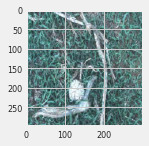

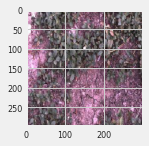

In [ ]:
batch = train_generator.next()[0]
showImage(batch[0])
showImage(batch[1])

In [ ]:
val_datagen = k.preprocessing.image.ImageDataGenerator(rescale=1./255)
valid_generator=val_datagen.flow_from_dataframe(directory=imgPath,
                                                  dataframe=df_val,
                                                  x_col='Filename',
                                                  y_col='Label',
#                                                   subset="validation",
                                                  batch_size=batch_size,
                                                  color_mode="rgb",
                                                  seed=seed,
                                                  shuffle=True,
                                                  class_mode="categorical",
                                                  target_size=getImgTensor(img_dim)[:2])

Found 17511 validated image filenames belonging to 9 classes.


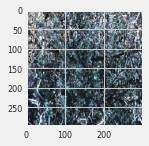

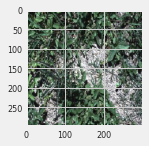

In [ ]:
batch = valid_generator.next()[0]
showImage(batch[0])
showImage(batch[1])

In [ ]:
test_datagen = k.preprocessing.image.ImageDataGenerator(rescale=1./255)

test_generator=test_datagen.flow_from_dataframe(directory=imgPath, 
                                                dataframe=df_test,
                                                x_col='Filename',
                                                y_col='Label',
                                                batch_size=1,
                                                color_mode="rgb",
                                                seed=seed,
                                                shuffle=False,
                                                class_mode="categorical",
#                                                 classes=['TEST'],
                                                target_size=getImgTensor(img_dim)[:2])

Found 17509 validated image filenames belonging to 9 classes.


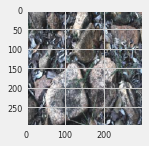

In [ ]:
batch = test_generator.next()[0]
showImage(batch[0])

In [ ]:
def plotModelHistory(h):
    fig, ax = plt.subplots(1, 2, figsize=(15,4))
    ax[0].plot(h.history['loss'])   
    ax[0].plot(h.history['val_loss'])
    ax[0].legend(['loss','val_loss'])
    ax[0].title.set_text("Train loss vs Validation loss")

    ax[1].plot(h.history['categorical_accuracy'])
    ax[1].plot(h.history['val_categorical_accuracy'])
    ax[1].legend(['categorical_accuracy','val_categorical_accuracy'])
    ax[1].title.set_text("Train accuracy vs Validation accuracy")

    print("Max. Training Accuracy", max(h.history['categorical_accuracy']))
    print("Max. Validaiton Accuracy", max(h.history['val_categorical_accuracy']))

In [ ]:
class myCallback(k.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        ACCURACY_THRESHOLD = 0.99
        if(logs.get('categorical_accuracy') > ACCURACY_THRESHOLD):
            print("\n\nStopping training as we have reached %2.2f%% accuracy!" %(ACCURACY_THRESHOLD*100))   
            self.model.stop_training = True

In [ ]:
# training model using train and val data
def trainModel(model, epochs, optimizer, vb=1, modelName='model'):
    bestModelPath = './'+modelName+'_model.hdf5'
    callback = myCallback()
    callbacks_list = [
        callback,
        k.callbacks.ReduceLROnPlateau(monitor = 'val_loss', patience = 5, verbose = 1, min_lr=0.00001), 
        k.callbacks.EarlyStopping(monitor = 'val_loss', patience = 15, verbose = 1, restore_best_weights = True), 
        k.callbacks.ModelCheckpoint(filepath=bestModelPath, monitor='val_loss', verbose=1, save_best_only=True)
    ]
    model.compile(optimizer=optimizer,
                  loss=k.losses.CategoricalCrossentropy(label_smoothing=.05),
                  metrics=[k.metrics.CategoricalAccuracy(), k.metrics.Precision(), k.metrics.Recall()]
    )
    train_generator.reset()
    
    steps_per_epoch = np.ceil(train_generator.n/train_generator.batch_size)
    validation_steps = np.ceil(valid_generator.n/valid_generator.batch_size)

    return model.fit_generator(generator=train_generator, steps_per_epoch=steps_per_epoch, 
                               validation_data=valid_generator, validation_steps=validation_steps, 
                               epochs=epochs, verbose=vb,
#                                class_weight=train_class_weights,
                               callbacks=callbacks_list)



In [ ]:
# evaluate model with time on test data
def evaluateModel(model, path=True):
    batch_size = test_generator.batch_size
    num_train_sequences = test_generator.n
    test_generator.reset()
    steps_per_epoch = 0
    if (test_generator.n%test_generator.batch_size) == 0:
        steps_per_epoch = int(test_generator.n/test_generator.batch_size)
    else:
        steps_per_epoch = int(test_generator.n//test_generator.batch_size) + 1

    t1 = time.time()
    if path:
        model = k.models.load_model(model)
    eval_results = model.evaluate_generator(test_generator, steps=steps_per_epoch)
    t2 = time.time()
    print(f'\nLoss: {eval_results[0]}, Accuracy: {eval_results[1]}, Precision: {eval_results[2]}, Recall: {eval_results[3]}')
    print(f'Prediction Time per Image: {(t2-t1)/valid_generator.n}')

In [ ]:
img_dim=299
mobilenet = k.applications.mobilenet_v2.MobileNetV2(weights='imagenet', input_shape=getImgTensor(img_dim), include_top=False)
mobilenet.trainable = False

model = k.models.Sequential([
                             mobilenet,
                             tf.keras.layers.GlobalAveragePooling2D(),
                             k.layers.Dropout(0.3),
                             k.layers.Dense(256, activation='relu'),
                            #  k.layers.BatchNormalization(),
                             k.layers.Dropout(0.25),
                            #  k.layers.Dense(128, activation='relu'),
                            #  k.layers.BatchNormalization(),
                            #  k.layers.Dropout(0.2),
                             k.layers.Dense(9, activation='softmax')
])
print(model.summary())

9406464/9406464 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 10, 10, 1280)     2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                           

In [ ]:
history_1 = trainModel(model, 1, 'adam', modelName='mobilenet')

NameError: ignored